In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
import math
import numpy as np
from collections import namedtuple, deque
import matplotlib.pyplot as plt

In [2]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        return self.layer3(x)


In [ ]:
# --- 2. define Replay Memory ---
# Transition used to store state, action, next_state, reward
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        # Save a transition
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
       # Sample a batch of transitions
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
# --- 3. set up environment, networks, optimizer, and replay memory ---
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9      # Epsilon starting value for epsilon-greedy action selection
EPS_END = 0.05       # Epsilon ending value
EPS_DECAY = 1000     # Epsilon decay rate
LR = 1e-4            # learning rate

# create environment and get number of actions and states
env = gym.make("CartPole-v1")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# generate some random actions and observe the state space
n_actions = env.action_space.n
state, info = env.reset()
n_observations = len(state)

# build networks and optimizer
# policy network used to select actions
policy_net = DQN(n_observations, n_actions).to(device)
# target network used to compute target Q values
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()  # target network is not trained

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0


In [ ]:
# --- 4. Epsilon-Greedy ---
def select_action(state):
    global steps_done
    sample = random.random()
    # Epsilon decay over time
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    
    if sample > eps_threshold:
        # choose action with highest Q value
        with torch.no_grad():
            # state need to add a batch dimension
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        # randomly choose an action
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)



In [ ]:
# --- 5. define optimization step ---
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    
    transitions = memory.sample(BATCH_SIZE)
    # use one batch of transitions to generate a Transition of batches
    batch = Transition(*zip(*transitions))

    # compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # calculate Q(s_t, a)
    # policy_net calculates Q values for all actions, we need to select the ones corresponding to the actions taken
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # calculate V(s_{t+1})
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        # use target_net to calculate the next state values
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    
    # calculate expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    #calculate Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # optimize the model
    optimizer.zero_grad()
    loss.backward()
    # cut off gradients to avoid explosion
    torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 100)
    optimizer.step()


Episode 10, Duration: 10
Episode 20, Duration: 12
Episode 30, Duration: 21
Episode 40, Duration: 11
Episode 50, Duration: 11
Episode 60, Duration: 10
Episode 70, Duration: 16
Episode 80, Duration: 12
Episode 90, Duration: 11
Episode 100, Duration: 8
Episode 110, Duration: 9
Episode 120, Duration: 11
Episode 130, Duration: 10
Episode 140, Duration: 10
Episode 150, Duration: 14
Episode 160, Duration: 18
Episode 170, Duration: 15
Episode 180, Duration: 15
Episode 190, Duration: 25
Episode 200, Duration: 17
Episode 210, Duration: 19
Episode 220, Duration: 22
Episode 230, Duration: 32
Episode 240, Duration: 40
Episode 250, Duration: 75
Episode 260, Duration: 86
Episode 270, Duration: 119
Episode 280, Duration: 120
Episode 290, Duration: 107
Episode 300, Duration: 142
Episode 310, Duration: 76
Episode 320, Duration: 104
Episode 330, Duration: 90
Episode 340, Duration: 122
Episode 350, Duration: 98
Episode 360, Duration: 96
Episode 370, Duration: 93
Episode 380, Duration: 105
Episode 390, Dur

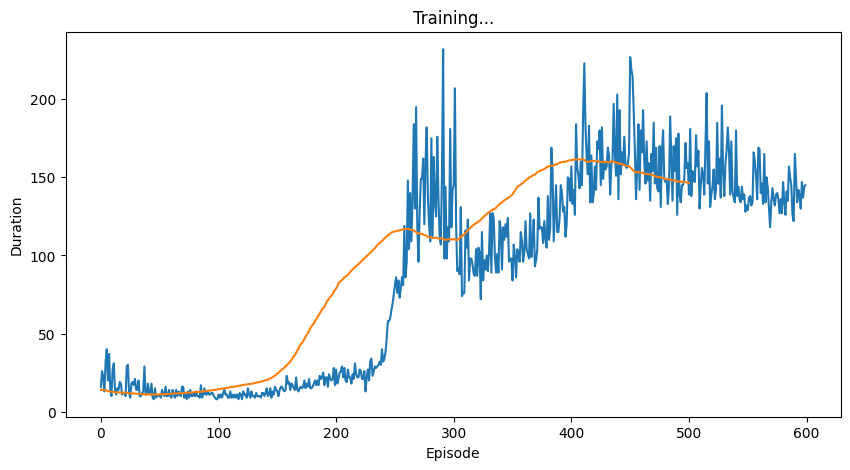

In [ ]:
# --- 6. training loop ---
num_episodes = 600
episode_durations = []

for i_episode in range(num_episodes):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    
    for t in range(500): # CartPole-v1  will terminate at 500 steps
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # put the transition into memory
        memory.push(state, action, next_state, reward)

        state = next_state

        # optimize the model
        optimize_model()

        if done:
            episode_durations.append(t + 1)
            if (i_episode + 1) % 10 == 0:
                print(f"Episode {i_episode+1}, Duration: {t+1}")
            break
            
    # update the target network, copying all weights and biases in DQN every 10 episodes
    if i_episode % 10 == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')

# 绘制结果
plt.figure(figsize=(10,5))
plt.title('Training...')
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.plot(episode_durations)
plt.plot(np.convolve(episode_durations, np.ones(100)/100, mode='valid')) # 绘制百次平均曲线
plt.show()
